In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!apt-get install unrar
!mkdir -p /content/dataset
!unrar x "/content/drive/MyDrive/output_frames.rar" "/content/dataset"
!ls /content/dataset
# !cp -r /content/dataset "/content/drive/MyDrive/dataset"

Streaming output truncated to the last 5000 lines.
Extracting  /content/dataset/output_frames/frame_31003.png                86%  OK 
Extracting  /content/dataset/output_frames/frame_31004.png                86%  OK 
Extracting  /content/dataset/output_frames/frame_31005.png                86%  OK 
Extracting  /content/dataset/output_frames/frame_31006.png                86%  OK 
Extracting  /content/dataset/output_frames/frame_31007.png                86%  OK 
Extracting  /content/dataset/output_frames/frame_31008.png                86%  OK 
Extracting  /content/dataset/output_frames/frame_31009.png                86%  OK 
Extracting  /content/dataset/output_frames/frame_31010.png                86%  OK 
Extracting  /content/dataset/output_frames/frame_31011.png                86%  OK 
Extracting  /content/dataset/output_frames/frame_31012.png                86%  OK 
Extracting  /content/dataset/

In [ ]:
!cp "/content/drive/MyDrive/kyotoA_kote.xlsx" "/content/"

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
import os
import re
import pandas as pd
from tqdm import tqdm

In [ ]:
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

In [ ]:
torch.manual_seed(42)
col_mins = []
col_maxs = []
def load_dataset(dataset_path, xlsx_path):
  df = pd.read_excel(xlsx_path)
  for col_idx in range(2, 5):  # Columns 2, 3, 4
        col = df.columns[col_idx]
        col_min = df[col].min()
        col_max = df[col].max()
        col_mins.append(col_min)
        col_maxs.append(col_max)
        if col_max != col_min:  # Avoid division by zero
            df[col] = (df[col] - col_min) / (col_max - col_min)
        else:
            df[col] = 0  # If all values are the same, set to 0
  data = []
  for i in tqdm(range(len(df) - 1)):
    image_path = os.path.join(dataset_path, "output_frames", f"frame_{i:05d}.png")
    if os.path.exists(image_path):
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
      image = cv2.resize(image, dsize=(160, 120))
      image = image / 255.0  # Normalize to [0,1]
      image = np.transpose(image, (2, 0, 1))  # Convert to (C, H, W)
      image_tensor = torch.tensor(image, dtype=torch.float32)
    else:
      continue  # Skip if image is missing

    row_data = df.iloc[i, 2:].values
    row_tensor = torch.tensor(row_data, dtype=torch.float32)

    next_pos = df.iloc[i + 1, 2:].values
    next_pos_tensor = torch.tensor(next_pos, dtype=torch.float32)

    data.append((image_tensor, row_tensor, next_pos_tensor))
  return data

100%|██████████| 36000/36000 [01:25<00:00, 420.69it/s]


Loaded 36000
First Image Shape: torch.Size([3, 120, 160])
First Position Shape: torch.Size([12])
First Position: tensor([ 0.0946,  0.4541,  0.9982,  0.9997, -0.0245, -0.0061,  0.0243,  0.9994,
        -0.0244,  0.0067,  0.0242,  0.9997])
[-79.63288, -0.096273, -1311.611867]
[778.541001, 881.350801, -0.024396]


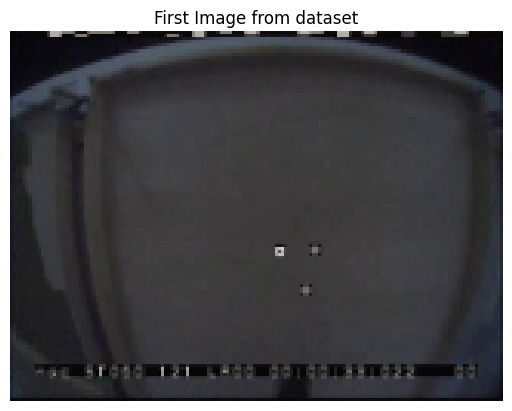

In [ ]:
dataset_path = "dataset"
xlsx_path = "kyotoA_kote.xlsx"
data = load_dataset(dataset_path,xlsx_path)

# Print dataset information
print(f"Loaded {len(data)}")
print(f"First Image Shape: {data[0][0].shape}")
print(f"First Position Shape: {data[0][1].shape}")
print(f"First Position: {data[0][1][0:]}")
print(col_mins)
print(col_maxs)
# Display the first image
plt.imshow(data[0][0].permute(1, 2, 0))
plt.axis('off')
plt.title("First Image from dataset")
plt.show()

In [ ]:
class ActionDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Create the dataset
dataset = ActionDataset(data)

Training Dataset Size: 28800
Testing Dataset Size: 7200
first image shape: torch.Size([3, 120, 160])
first position: tensor([ 0.3585,  0.6823,  0.9827,  0.9998, -0.0210,  0.0057,  0.0194,  0.9792,
         0.2020, -0.0099, -0.2018,  0.9794])
train dataloader image shape: torch.Size([32, 3, 120, 160])
train dataloader position shape: torch.Size([32, 12])


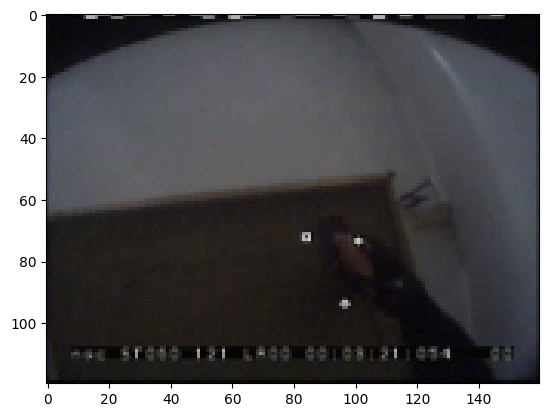

In [ ]:
from torch.utils.data import random_split

train_size = int(0.8 * len(data))  # ~28,801
test_size = len(data) - train_size  # ~7,200
train_dataset, test_dataset = random_split(data, [train_size, test_size])

# Create DataLoaders for the training and test sets
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


print(f"Training Dataset Size: {len(train_dataset)}")
print(f"Testing Dataset Size: {len(test_dataset)}")
print(f"first image shape: {test_dataset[0][0].shape}")
print(f"first position: {test_dataset[0][1]}")
plt.imshow(test_dataset[2][0].permute(1, 2, 0))
print(f"train dataloader image shape: {next(iter(train_dataloader))[0].shape}")
print(f"train dataloader position shape: {next(iter(train_dataloader))[1].shape}")

In [ ]:
import torch
import torch.nn as nn

class RobotArmMovement(nn.Module):
    def __init__(self, pos_dim = 12, hidden_dim=256):
        super(RobotArmMovement, self).__init__()
        self.pos_dim = pos_dim
        self.hidden_dim = hidden_dim

        # CNN for image feature extraction
        self.cnn = nn.Sequential(
          nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(16),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.AdaptiveAvgPool2d((8, 6)),
        )

        # Distance feature extraction
        self.distance_fc = nn.Sequential(
            nn.Linear(self.pos_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )

        # Feature projection to hidden_dim
        self.feature_fc = nn.Sequential(
            # nn.Flatten(),
            nn.Linear(64 * 8 * 6 + 256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, self.pos_dim),
        )

        # LSTM for temporal modeling
        # self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=2, batch_first=True)

        # self.output_fc = nn.Linear(hidden_dim, pos_dim)


    def create_mask(self, joint_angles_tensor, padding_value=-1.0):
        # Create a mask: 1 where joint angles are not equal to padding value, 0 where they are
        mask = (joint_angles_tensor != padding_value).float().prod(dim=-1)  # Shape: (batch, max_seq_len)
        return mask

    # def forward(self, image, pos, padding_mask=None):
    #     # Extract features from image and distance
    #     cnn_features = self.cnn(image)
    #     cnn_features = cnn_features.view(cnn_features.size(0), -1)  # Shape: (batch, 128 * 16 * 9)

    #     distance_features = self.distance_fc(pos)  # Shape: (batch, 256)

    #     combined_features = torch.cat((cnn_features, distance_features), dim=1)  # Shape: (batch, 128 * 16 * 9 + 256)
    #     features = self.feature_fc(combined_features)  # Shape: (batch, hidden_dim)

    #     # Repeat features for each timestep to create a sequence
    #     features = features.unsqueeze(1).repeat(1, self.max_seq_len, 1)  # Shape: (batch, max_seq_len, hidden_dim)
    def forward(self, image, pos):
      cnn_features = self.cnn(image)
      cnn_features = cnn_features.view(cnn_features.size(0), -1)

      distance_features = self.distance_fc(pos)

      combined_features = torch.cat((cnn_features, distance_features), dim=1)

      output = self.feature_fc(combined_features)
      # output = self.clip_output(output)
      return output
        # # Apply LSTM with padding mask
        # if padding_mask is not None:
        #     # Convert padding mask to lengths for pack_padded_sequence
        #     lengths = (padding_mask == 0).sum(dim=1).cpu()  # Number of non-padded timesteps per sample
        #     lengths = torch.clamp(lengths, min=1)  # Ensure at least 1 timestep to avoid errors
        #     packed_features = torch.nn.utils.rnn.pack_padded_sequence(
        #         features, lengths, batch_first=True, enforce_sorted=False
        #     )
        #     packed_output, _ = self.lstm(packed_features)
        #     output, _ = torch.nn.utils.rnn.pad_packed_sequence(
        #         packed_output, batch_first=True, total_length=self.max_seq_len
        #     )
        # else:
        #     output, _ = self.lstm(features)  # Shape: (batch, max_seq_len, hidden_dim)

        # # Output for each timestep
        # output = self.output_fc(output)  # Shape: (batch, max_seq_len, action_dim)

        # # Flatten the output to (batch_size, action_dim * max_seq_len)
        # output = output.view(-1, self.max_seq_len * self.action_dim)  # Shape: (batch, action_dim * max_seq_len)
        # return output

# Test the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RobotArmMovement().to(device)
image = torch.randn(32, 3, 160, 120, device=device)
distance = torch.randn(32, 12, device=device)
output = model(image, distance)

print(f"Output Shape: {output.shape}")
# print(f"Sample batch in training dataloader: {next(iter(train_dataloader))[1].shape}")

Output Shape: torch.Size([32, 12])


In [ ]:
import torch.optim as optim

model = RobotArmMovement().to(device)
criterion = nn.L1Loss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
num_epochs = 50

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for i, data in enumerate(train_dataloader):
        image, pos, next_pos = data
        image, pos, next_pos = image.to(device), pos.to(device), next_pos.to(device)
        optimizer.zero_grad()
        output = model(image, pos)
        loss = criterion(output, next_pos)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(test_dataloader):
          image, pos, next_pos = data
          image, pos, next_pos = image.to(device), pos.to(device), next_pos.to(device)
          outputs = model(image, pos)
          loss = criterion(outputs, next_pos)
          test_loss += loss.item()
    test_loss /= len(test_dataloader)
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

Epoch 1/50, Train Loss: 0.0843, Test Loss: 0.0387
Epoch 2/50, Train Loss: 0.0654, Test Loss: 0.0387
Epoch 3/50, Train Loss: 0.0593, Test Loss: 0.0327
Epoch 4/50, Train Loss: 0.0559, Test Loss: 0.0410
Epoch 5/50, Train Loss: 0.0528, Test Loss: 0.0313
Epoch 6/50, Train Loss: 0.0498, Test Loss: 0.0292
Epoch 7/50, Train Loss: 0.0464, Test Loss: 0.0258
Epoch 8/50, Train Loss: 0.0433, Test Loss: 0.0305
Epoch 9/50, Train Loss: 0.0420, Test Loss: 0.0251
Epoch 10/50, Train Loss: 0.0404, Test Loss: 0.0222
Epoch 11/50, Train Loss: 0.0384, Test Loss: 0.0282
Epoch 12/50, Train Loss: 0.0370, Test Loss: 0.0227
Epoch 13/50, Train Loss: 0.0359, Test Loss: 0.0246
Epoch 14/50, Train Loss: 0.0345, Test Loss: 0.0189
Epoch 15/50, Train Loss: 0.0334, Test Loss: 0.0198
Epoch 16/50, Train Loss: 0.0325, Test Loss: 0.0184
Epoch 17/50, Train Loss: 0.0316, Test Loss: 0.0199
Epoch 18/50, Train Loss: 0.0309, Test Loss: 0.0184
Epoch 19/50, Train Loss: 0.0299, Test Loss: 0.0206
Epoch 20/50, Train Loss: 0.0299, Test Lo

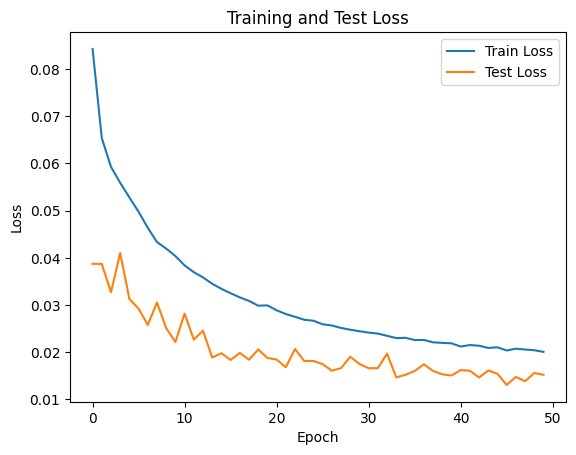

In [ ]:
# Plot the training and test losses
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')
plt.show()

Sample 0 - Target Next Joint Values (Un-normalized):
  World Coordinates (X, Y, Z): [227.2229 594.3274 -22.7917]
  Local Rotations: [ 0.9997 -0.0236  0.0076  0.0216  0.9793  0.2015 -0.0122 -0.2012  0.9795]
Sample 0 - Predicted Next Joint Values (Un-normalized):
  World Coordinates (X, Y, Z): [225.3667 596.8178 -17.391 ]
  Local Rotations: [ 1.0052e+00 -4.5800e-02  6.0000e-04  4.3900e-02  9.8580e-01  2.0270e-01
 -2.1400e-02 -1.9520e-01  9.8400e-01]
Average Test Loss (L1): 0.0152
R^2 Score (World Coordinates): 0.9986
R^2 Score (Local Rotations): 0.9969


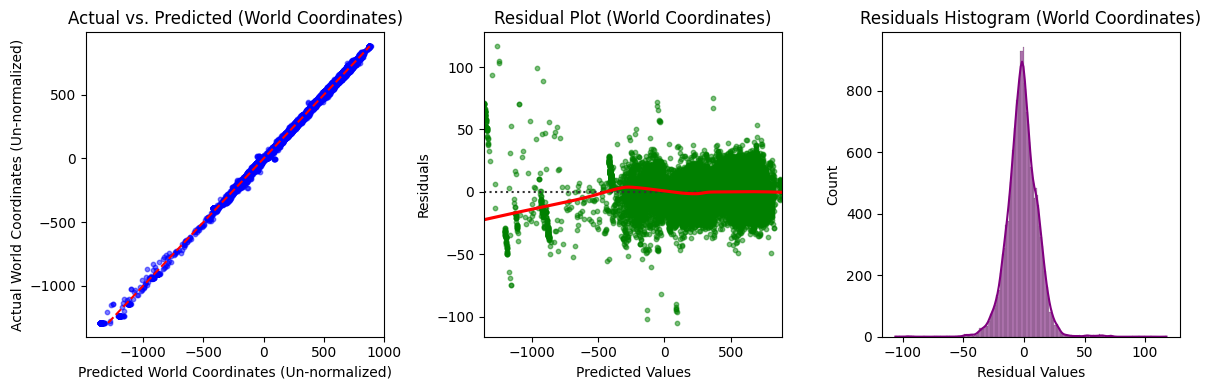

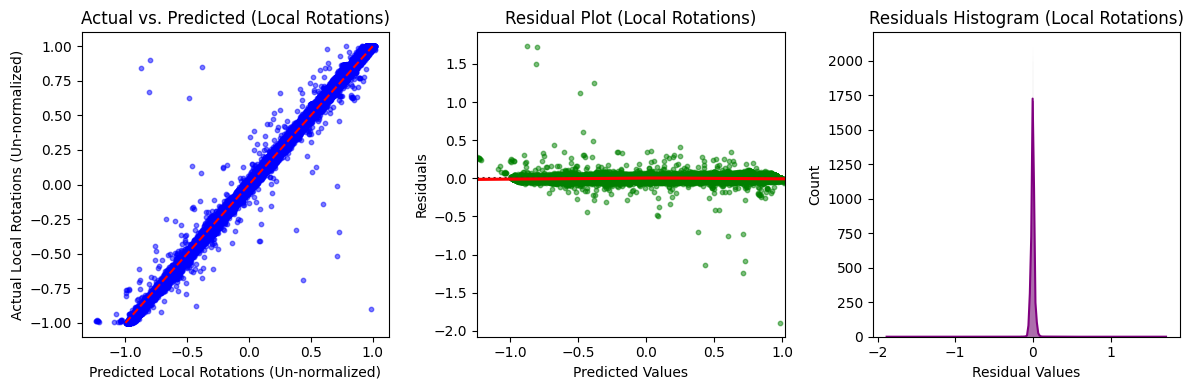

First 2 samples - Target Next Joint Values (Un-normalized):
Sample 0:
  World Coordinates (Z, xx, xy): [227.2229 594.3274 -22.7917]
  Local Rotations: [ 0.9997 -0.0236  0.0076  0.0216  0.9793  0.2015 -0.0122 -0.2012  0.9795]
Sample 1:
  World Coordinates (Z, xx, xy): [464.4666 228.987  -15.1199]
  Local Rotations: [ 0.9882 -0.1521 -0.0194  0.1532  0.9848  0.0819  0.0066 -0.0839  0.9964]
First 2 samples - Predicted Next Joint Values (Un-normalized):
Sample 0:
  World Coordinates (Z, xx, xy): [225.3667 596.8178 -17.391 ]
  Local Rotations: [ 1.0052e+00 -4.5800e-02  6.0000e-04  4.3900e-02  9.8580e-01  2.0270e-01
 -2.1400e-02 -1.9520e-01  9.8400e-01]
Sample 1:
  World Coordinates (Z, xx, xy): [485.8086 246.563   -6.8793]
  Local Rotations: [ 0.985  -0.1609 -0.0199  0.1694  0.9794  0.0888 -0.0119 -0.0933  0.9974]


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn

def calculate_r2(y_true, y_pred):
    y_true = y_true.float()
    y_pred = y_pred.float()
    y_mean = torch.mean(y_true)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - y_mean) ** 2)
    return 1 - ss_res / ss_tot if ss_tot > 0 else 0

def unnormalize(values, col_mins, col_maxs):
    unnorm_values = values.copy()
    for j in range(3):  # Only first 3 columns (Z, xx, xy)
        unnorm_values[:, j] = unnorm_values[:, j] * (col_maxs[j] - col_mins[j]) + col_mins[j]
    return unnorm_values

# Evaluation
all_next_pos = []
all_outputs = []
total_loss = 0.0
criterion = nn.L1Loss()

model.eval()
with torch.no_grad():
    for i, (image, pos, next_pos) in enumerate(test_dataloader):
        image = image.to(device)
        pos = pos.to(device)
        next_pos = next_pos.to(device)
        output = model(image, pos)
        loss = criterion(output, next_pos)
        total_loss += loss.item()
        all_next_pos.append(next_pos.cpu())
        all_outputs.append(output.cpu())

        if i == 0:
            next_pos_np = next_pos.cpu().numpy()
            output_np = output.cpu().numpy()
            next_pos_unnorm = unnormalize(next_pos_np, col_mins, col_maxs)[0]
            output_unnorm = unnormalize(output_np, col_mins, col_maxs)[0]
            print("Sample 0 - Target Next Joint Values (Un-normalized):")
            print("  World Coordinates (X, Y, Z):", np.round(next_pos_unnorm[:3], 4))
            print("  Local Rotations:", np.round(next_pos_unnorm[3:], 4))
            print("Sample 0 - Predicted Next Joint Values (Un-normalized):")
            print("  World Coordinates (X, Y, Z):", np.round(output_unnorm[:3], 4))
            print("  Local Rotations:", np.round(output_unnorm[3:], 4))

all_next_pos = torch.cat(all_next_pos, dim=0)  # Shape: (7200, 11)
all_outputs = torch.cat(all_outputs, dim=0)    # Shape: (7200, 11)

avg_loss = total_loss / len(test_dataloader)
print(f"Average Test Loss (L1): {avg_loss:.4f}")

# Split into world coordinates and local rotations
next_pos_np = all_next_pos.numpy()  # (7200, 11)
output_np = all_outputs.numpy()     # (7200, 11)
next_pos_unnorm = unnormalize(next_pos_np, col_mins, col_maxs)
output_unnorm = unnormalize(output_np, col_mins, col_maxs)

# World coordinates (Z, xx, xy)
next_pos_world = next_pos_unnorm[:, :3]  # (7200, 3)
output_world = output_unnorm[:, :3]      # (7200, 3)
residuals_world = next_pos_world - output_world

# Local rotations (remaining 8 values)
next_pos_local = next_pos_unnorm[:, 3:]  # (7200, 8)
output_local = output_unnorm[:, 3:]      # (7200, 8)
residuals_local = next_pos_local - output_local

# R² for each group
r2_world = calculate_r2(torch.tensor(next_pos_world), torch.tensor(output_world))
r2_local = calculate_r2(torch.tensor(next_pos_local), torch.tensor(output_local))
print(f"R^2 Score (World Coordinates): {r2_world.item():.4f}")
print(f"R^2 Score (Local Rotations): {r2_local.item():.4f}")

# Plot for World Coordinates
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.scatter(output_world.flatten(), next_pos_world.flatten(), color='blue', alpha=0.5, s=10)
plt.plot([min(next_pos_world.flatten()), max(next_pos_world.flatten())],
         [min(next_pos_world.flatten()), max(next_pos_world.flatten())], 'r--')
plt.xlabel('Predicted World Coordinates (Un-normalized)')
plt.ylabel('Actual World Coordinates (Un-normalized)')
plt.title('Actual vs. Predicted (World Coordinates)')

plt.subplot(1, 3, 2)
sns.residplot(x=output_world.flatten(), y=residuals_world.flatten(), color='green', lowess=True,
              scatter_kws={'alpha': 0.5, 's': 10}, line_kws={'color': 'red'})
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (World Coordinates)')

plt.subplot(1, 3, 3)
sns.histplot(residuals_world.flatten(), kde=True, color='purple')
plt.xlabel('Residual Values')
plt.title('Residuals Histogram (World Coordinates)')
plt.tight_layout()
plt.show()

# Plot for Local Rotations
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.scatter(output_local.flatten(), next_pos_local.flatten(), color='blue', alpha=0.5, s=10)
plt.plot([min(next_pos_local.flatten()), max(next_pos_local.flatten())],
         [min(next_pos_local.flatten()), max(next_pos_local.flatten())], 'r--')
plt.xlabel('Predicted Local Rotations (Un-normalized)')
plt.ylabel('Actual Local Rotations (Un-normalized)')
plt.title('Actual vs. Predicted (Local Rotations)')

plt.subplot(1, 3, 2)
sns.residplot(x=output_local.flatten(), y=residuals_local.flatten(), color='green', lowess=True,
              scatter_kws={'alpha': 0.5, 's': 10}, line_kws={'color': 'red'})
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (Local Rotations)')

plt.subplot(1, 3, 3)
sns.histplot(residuals_local.flatten(), kde=True, color='purple')
plt.xlabel('Residual Values')
plt.title('Residuals Histogram (Local Rotations)')
plt.tight_layout()
plt.show()

# First 2 samples
print("First 2 samples - Target Next Joint Values (Un-normalized):")
for i in range(2):
    print(f"Sample {i}:")
    print("  World Coordinates (Z, xx, xy):", np.round(next_pos_unnorm[i, :3], 4))
    print("  Local Rotations:", np.round(next_pos_unnorm[i, 3:], 4))
print("First 2 samples - Predicted Next Joint Values (Un-normalized):")
for i in range(2):
    print(f"Sample {i}:")
    print("  World Coordinates (Z, xx, xy):", np.round(output_unnorm[i, :3], 4))
    print("  Local Rotations:", np.round(output_unnorm[i, 3:], 4))

In [ ]:
torch.save(model.state_dict(), "modelV1_n.pth")

model_test = RobotArmMovement().to(device)
model_test.load_state_dict(torch.load("modelV1_n.pth"))

model_test

<ipython-input-13-f29b7584d0ee>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_test.load_state_dict(torch.load("modelV1_n.pth"))


RobotArmMovement(
  (cnn): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): AdaptiveAvgPool2d(output_size=(8, 6))
  )
  (distance_fc): Sequential(
    (0): Linear(in_features=12, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
 